In [38]:
# Goal of the project is to apply ML to real data

# Step 1: just plot the data
# Step 2: which task? Supervised Learning!
# Step 3: train and test a few methods

# Comments on different algorithms, expenses, difficulties, findings?

In [39]:
# Here I want to use a CNN for reproducing the 'probability' distribution of all classes and sub-classes

In [40]:
# Loading the data

# What are the GalaxyIDs? I can read them from the first column of the training_solutions file

import skimage
from skimage import data
from skimage import io

import numpy as np
import os
import csv

# I read the file and create the list of IDs as well as the list of labels
with open("training_solutions_rev1.csv", 'r') as f: 
    reader = csv.reader(f, delimiter=",")
    train_ids = []
    y = []
    for k, line in enumerate(reader):
        if k == 0: continue # skip header
        train_ids.append(int(line[0]))
        y.append(line[1:])
        
train_ids = np.array(train_ids) # I save the IDs in this numpy array
my_train_ids = train_ids[0:8000] # I want to work with less training data for computational cost reasons
my_valid_ids = train_ids[8000:9000] # galaxies IDs for my validation test (to chooose between my models)
my_test_ids = train_ids[9000:10000] # These I choose to be the galaxies IDs for my final-test

# same split for the labels
y = np.asarray(y, dtype=float)  #change type of elements from string to float!
y_train = y[0:8000]
y_valid = y[8000:9000]
y_test = y[9000:10000]

# same split for the data points
x_train = []
x_valid = []
x_test = []
for ID in my_train_ids:
    filename = 'images_training_rev1/' + str(ID) + '.jpg'
    x_train.append(io.imread(filename))
for ID in my_valid_ids:
    filename = 'images_training_rev1/' + str(ID) + '.jpg'
    x_valid.append(io.imread(filename))
for ID in my_test_ids:
    filename = 'images_training_rev1/' + str(ID) + '.jpg'
    x_test.append(io.imread(filename))
x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

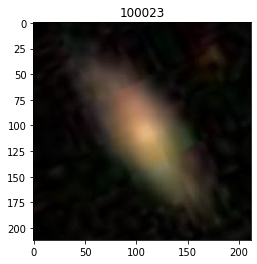

In [41]:
# cropping the images... because the galaxies take only a small area in the centre
# what is outside the central square 212x212 is not discriminative

x_train_cr = []
x_valid_cr = []
x_test_cr = []
for x in x_train:
    crop = x[106:318,106:318,:]
    x_train_cr.append(crop)
for x in x_valid:
    crop = x[106:318,106:318,:]
    x_valid_cr.append(crop)
for x in x_test:
    crop = x[106:318,106:318,:]
    x_test_cr.append(crop)
    
x_train_cr = np.array(x_train_cr)
x_valid_cr = np.array(x_valid_cr)
x_test_cr = np.array(x_test_cr)

# Plotting a cropped galaxy from the training set...
import matplotlib.pyplot as plt
plt.imshow(x_train_cr[1]) 
plt.title(my_train_ids[1])
plt.savefig('cropped_galaxy.pdf')

In [42]:
# Each data point is an image of 424x424 pixels, 
# where each pixel is a set of 3 numbers giving the RGB intensities

x_train_cr = np.asarray(x_train_cr, dtype=float)
x_valid_cr = np.asarray(x_valid_cr, dtype=float)
x_test_cr = np.asarray(x_test_cr, dtype=float)

print('The number of values characterizing each image is:')
print(212*212*3)
print('The shape of each data point is:')
print(x_train_cr[0].shape)

print('The shapes of the training points and of the labels are:')
print(x_train_cr.shape, y_train.shape)

The number of values characterizing each image is:
134832
The shape of each data point is:
(212, 212, 3)
The shapes of the training points and of the labels are:
(8000, 212, 212, 3) (8000, 37)


In [43]:
# Comments:
# 1. I can use COLAB, a google notebook that connects to a GPU in the worlds...

In [44]:
import tensorflow as tf
print(tf.__version__) 

2.0.0


In [45]:
# I want to construct a CNN because the images have a lot of pixels
# implying a lot of weigths to learn...
# It is smart to use filters (convolutional layers) to detect patterns
# e.g. spiral arms, bars, round shapes, edge-on disks, bulges, rings, exc...

In [46]:
#Normalization generally leads to faster learning/convergence - a good practice!
x_train_cr = tf.keras.utils.normalize(x_train_cr, axis=1)
x_valid_cr = tf.keras.utils.normalize(x_valid_cr, axis=1)

#We define a linear-style neural network, one of the simplest models
model = tf.keras.models.Sequential()

In [47]:
# 1st convolution layer with 10 large filters 
model.add(tf.keras.layers.Conv2D(10,(7,7),input_shape=(212, 212, 3)))

# 1st pooling layer to coarse-grain by a factor of 4 (get the size of a galaxy)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(4,4)))

# 2nd convolution layer with 10 smaller filters
model.add(tf.keras.layers.Conv2D(10,(5,5),input_shape=(54, 54, 3)))

# 2nd pooling layer to coarse-grain by a factor of 2
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

In [48]:
# Flatten the input in 1D array 
model.add(tf.keras.layers.Flatten())

# Dense layer with 128 neurons
model.add(tf.keras.layers.Dense(128,activation = tf.nn.relu))

# For the final layer, the output layer, we transform the output from the previous layer
# to a probability distribution across 37 classes
last_layer = 37
model.add(tf.keras.layers.Dense(last_layer,activation = tf.nn.softmax))

# I choose the loss function and the optimizer ('adam' is a variant of SGD)
model.compile(optimizer="adam",loss=tf.keras.losses.Huber(),metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [49]:
model.fit(x_train_cr, y_train,epochs = 4)

Train on 8000 samples
Epoch 1/4
8000/8000 [==============================] - 81s 10ms/sample - loss: 0.0241 - rmse: 0.2197
Epoch 2/4
8000/8000 [==============================] - 81s 10ms/sample - loss: 0.0233 - rmse: 0.2157
Epoch 3/4
8000/8000 [==============================] - 80s 10ms/sample - loss: 0.0231 - rmse: 0.2149
Epoch 4/4
8000/8000 [==============================] - 80s 10ms/sample - loss: 0.0229 - rmse: 0.2142


In [50]:
# CNN took 7s per epoch with 800 training points 
# rmse = 0.22 with Huber loss (a good value of rmse is 0.1)
# it doesn't improve performance but it allows to use more data with same computational cost!

# CNN took 80s per epoch with 8000 training points
# rmse = 0.21 with Huber loss ...not a great improvement



In [51]:
#Let's evaluate the model
#.evaluate() returns the loss and metrics (accuracy for us) for the test sample
val_loss, val_rmse = model.evaluate(x_valid_cr, y_valid)
print(val_loss, val_rmse)

1000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.023365648418664932 0.21617422


In [52]:
# rmse = 0.22 ...WORSE!
# the first 50 scores in the ranking are 0.07-0.1

In [53]:
#Saves the model in a folder in the working directory
model.save("CNN_Galaxies_crop+regression")

INFO:tensorflow:Assets written to: CNN_Galaxies_crop+regression/assets


Predicted labels
[5.9070460e-02 1.5579151e-01 1.1865116e-06 2.3367013e-05 3.4875255e-02
 1.5581950e-06 3.7194623e-03 1.8242492e-06 1.0492591e-06 3.4156125e-07
 7.4648386e-07 9.8709768e-07 3.2926627e-07 3.9262426e-07 7.4650532e-01
 2.5586661e-07 1.6167603e-07 1.2376215e-07 3.7671805e-07 4.4706513e-07
 6.0998144e-07 5.1971080e-07 2.4912342e-07 1.4186898e-07 2.1622182e-07
 1.6598032e-07 2.4427817e-07 1.2514855e-07 5.3932939e-07 1.7358380e-07
 3.0802474e-07 1.3203218e-07 1.6017968e-07 4.1359388e-07 2.2280035e-07
 3.4815281e-07 3.1534495e-07]
Human labels
[2.93253000e-01 7.05975000e-01 7.72000000e-04 2.19025214e-01
 4.86949786e-01 0.00000000e+00 4.86949786e-01 1.02709884e-01
 3.84239902e-01 0.00000000e+00 2.75925714e-01 2.11024072e-01
 0.00000000e+00 1.09302000e-01 8.90698000e-01 1.02084300e-02
 1.74691105e-01 1.08353464e-01 2.73255000e-02 2.73255000e-02
 0.00000000e+00 2.73255000e-02 2.73255000e-02 0.00000000e+00
 0.00000000e+00 2.19025214e-01 0.00000000e+00 0.00000000e+00
 1.02709884e-01 

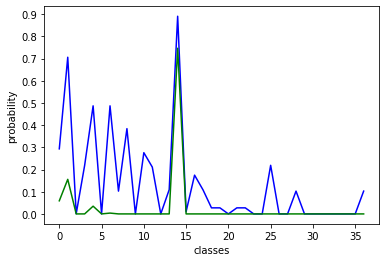

In [59]:
#Load the model
my_model = tf.keras.models.load_model("CNN_Galaxies_crop+regression")

#Test the model
predictions = my_model.predict(x_valid_cr)

#For a given index...
index = 300

#What do we predict?
print('Predicted labels')
print(predictions[index])

#What is the true value?
print('Human labels')
print(y_valid[index])

# I need to plot for a visual feeling
import matplotlib.pyplot as plt

plt.plot(np.arange(37), y_valid[index], c='b')
plt.plot(np.arange(37), predictions[index], c='g')
plt.yticks(np.arange(0,1,0.1))
plt.ylabel('probability')
plt.xlabel('classes')
plt.savefig('distribution_predicted.pdf')